<a href="https://colab.research.google.com/github/ihatestudysomuch/pytorch/blob/main/Pytorch_26%EC%9E%A5_LSTM%EC%9C%BC%EB%A1%9C_%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EA%B0%80_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [19]:
DEVICE = torch.device("cuda")  if torch.cuda.is_available() else torch.device("cpu") # ndivia drive 없음

print(f"using PyTorch version: {torch.__version__}, Device: {DEVICE}")

using PyTorch version: 2.5.1+cu121, Device: cpu


In [7]:
# 하이퍼 파라미터

FEATURE_NUMS = 4        # 입력층으로 들어가는 데이터 개수 feature
SEQ_LENGTH = 5          # 정답을 만들기 위해 필요한 시점 개수 time step
HIDDEN_SIZE = 4         # RNN 계열 계층을 구성하는 hidden state 개수
NUM_LAYERS = 1          # RNN 계열 계층이 몇겹으로 쌓였는지 나타냄
LEARNING_RATE = 1e-3    # 학습율
BATCH_SIZE = 20         # 학습을 위한 배치사이즈 개수

In [9]:
# FinanceDataReader 패키지에서 Pnadas DataFrame으로 삼성전자 주가 다운로드

!pip install finance-datareader

import FinanceDataReader as fdr

df = fdr.DataReader('005930', '2020-01-01', '2024-06-30')

df = df[ ['Open', 'High', 'Low', 'Volume', 'Close'] ]

df.head(10)

df = fdr.DataReader('005930', '2020-01-01', '2024-06-30')

df = df[ ['Open', 'High', 'Low', 'Volume', 'Close'] ]

df.head(10)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 3.2 MB/s eta 0:00:00


,Open,High,Low,Volume,Close
Date,,,,,
2020-01-02,55500,56000,55000,12993228,55200
2020-01-03,56000,56600,54900,15422255,55500
2020-01-06,54900,55600,54600,10278951,55500
2020-01-07,55700,56400,55600,10009778,55800
2020-01-08,56200,57400,55900,23501171,56800
2020-01-09,58400,58600,57400,24102579,58600
2020-01-10,58800,59700,58300,16000170,59500
2020-01-13,59600,60000,59100,11359139,60000
2020-01-14,60400,61000,59900,16906295,60000


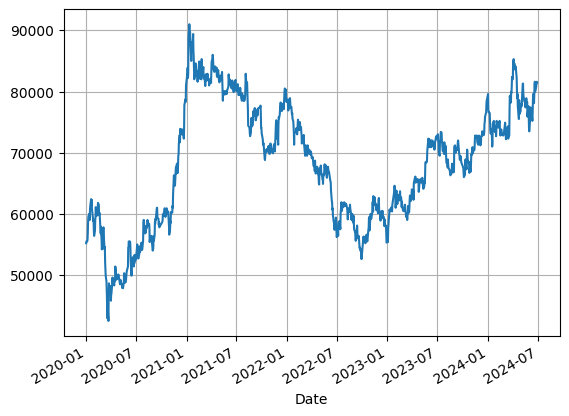

In [10]:
df['Close'].plot().grid() # 주가 시각화

In [11]:
SPLIT = int(0.7*len(df)) # train, test 7:3

train_df = df[:SPLIT]
test_df = df[SPLIT:]

In [15]:
scaler_x = MinMaxScaler() # MinMaxScaler()로 0과 1사이의 값을 가지도록 Scaling

train_df.iloc[:,:-1] = scaler_x.fit_transform(train_df.iloc[:,:-1])
test_df.iloc[:,:-1] = scaler_x.fit_transform(test_df.iloc[:,:-1])

scaler_y = MinMaxScaler() # MinMaxScaler()로 0과 1사이의 값을 가지도록 Scaling

train_df.iloc[:,-1] = scaler_y.fit_transform(train_df.iloc[:,[-1]])
test_df.iloc[:,-1] = scaler_y.fit_transform(test_df.iloc[:,[-1]])

<ipython-input-15-ddd580913d88>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.14068441 0.11787072 0.07984791 0.11406844 0.08745247 0.05703422
 0.0608365  0.06844106 0.05703422 0.09505703 0.06463878 0.04942966
 0.0418251  0.01901141 0.03802281 0.         0.03041825 0.03422053
 0.08745247 0.04562738 0.04942966 0.07984791 0.12547529 0.15209125
 0.11787072 0.14828897 0.14068441 0.15969582 0.19011407 0.15589354
 0.17490494 0.18631179 0.12547529 0.22813688 0.25475285 0.26235741
 0.2661597  0.26996198 0.23193916 0.23954373 0.25095057 0.24714829
 0.23954373 0.25475285 0.23574144 0.17490494 0.19391635 0.21292776
 0.24714829 0.25475285 0.24334601 0.23193916 0.26235741 0.23954373
 0.21292776 0.19771863 0.19391635 0.20912548 0.24334601 0.22813688
 0.27376426 0.35741445 0.36121673 0.35741445 0.36121673 0.37262357
 0.42965779 0.50570342 0.47148289 0.45247148 0.50190114 0.48288973
 0.45627376 0.45247148 0.49429658 0.4562737

In [16]:
def MakeSeqNumpyData(data, seq_length):

    x_seq_list = []
    y_seq_list = []

    for i in range(len(data) - seq_length):
        x_seq_list.append(data[ i:i+seq_length, :-1 ]) # 1~5일간의 데이터를 모은다고 가정
        y_seq_list.append(data[ i+seq_length, [-1] ]) # 그 경우 6일차의 주가를 예측

    x_seq_numpy = np.array(x_seq_list)
    y_seq_numpy = np.array(y_seq_list)

    return x_seq_numpy, y_seq_numpy

In [17]:
# train, test 데이터 생성
x_train_data, y_train_data = MakeSeqNumpyData(np.array(train_df), SEQ_LENGTH)

x_test_data, y_test_data = MakeSeqNumpyData(np.array(test_df), SEQ_LENGTH)

print(x_train_data.shape, y_train_data.shape)
print(x_test_data.shape, y_test_data.shape)

(770, 5, 4) (770, 1)
(328, 5, 4) (328, 1)


In [20]:
# tensor 데이터 생성
x_train_tensor = torch.FloatTensor(x_train_data).to(DEVICE)
x_test_tensor = torch.FloatTensor(x_test_data).to(DEVICE)

y_train_tensor = torch.FloatTensor(y_train_data).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test_data).to(DEVICE)

# dataset 정의
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# dataloader 정의
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [22]:
# 모델 정의
class MyLSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1) # 하나의 출력값

    # 피드포워드
    def forward(self, data):
        # 은닉, 셀 상태 정의(0으로 초기화)
        h0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(DEVICE)
        c0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(DEVICE)

        outputs, _ = self.lstm(data, (h0, c0)) # time steps 전부의 시점
        last_hs = outputs[:, -1, :] # 마지막 time steps (slicing 하는 거 보니 마지막값 맞음)
        prediction = self.fc(last_hs) # Fully Connected Layer

        return prediction

In [23]:
# 손실함수, 옵티마이저
model = MyLSTMModel(FEATURE_NUMS, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
def model_train(dataloader, model, loss_function, optimizer):

    # traning 즉, 학습모드 on
    model.train()

    train_loss_sum = 0

    total_train_batch = len(dataloader)

    for inputs, labels in dataloader:

        x_train = inputs.to(DEVICE)
        y_train = labels.to(DEVICE)

        outputs = model(x_train) # 예측값
        loss = loss_function(outputs, y_train) # 오차

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

    train_avg_loss = train_loss_sum / total_train_batch

    return train_avg_loss

In [27]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    # evaluation 즉, 평가모드 on
    model.eval()

    with torch.no_grad():

        val_loss_sum = 0

        total_val_batch = len(dataloader)

        for inputs, labels in dataloader:

            x_val = inputs.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val) # 예측값
            loss = loss_function(outputs, y_val) # 오차

            val_loss_sum += loss.item()

        val_avg_loss = val_loss_sum / total_val_batch

    return val_avg_loss

In [28]:
from datetime import datetime

train_loss_list = []

start_time = datetime.now()

EPOCHS = 200

# 200번 반복
for epoch in range(EPOCHS):

    avg_loss = model_train(train_dataloader, model, loss_function, optimizer)

    train_loss_list.append(avg_loss)

    if (epoch % 10 == 0):
        print('epoch: ', epoch, ', train loss = ', avg_loss)

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)


epoch:  0 , train loss =  0.8463010100217966
epoch:  10 , train loss =  0.003214965917719289
epoch:  20 , train loss =  0.001577426264516245
epoch:  30 , train loss =  0.001206830821525401
epoch:  40 , train loss =  0.0010878156209424234
epoch:  50 , train loss =  0.0009849567745382397
epoch:  60 , train loss =  0.0009440950047857582
epoch:  70 , train loss =  0.0008993502989865076
epoch:  80 , train loss =  0.0008782420758134088
epoch:  90 , train loss =  0.0008466735001629553
epoch:  100 , train loss =  0.0008604651554308545
epoch:  110 , train loss =  0.0008200602993989984
epoch:  120 , train loss =  0.0007874726053649703
epoch:  130 , train loss =  0.0007889543351036712
epoch:  140 , train loss =  0.0007620698698491862
epoch:  150 , train loss =  0.0007805343902407166
epoch:  160 , train loss =  0.0007542048577959529
epoch:  170 , train loss =  0.000741665682140499
epoch:  180 , train loss =  0.0007243078490808749
epoch:  190 , train loss =  0.0007222400320013269
elapsed time =>  0

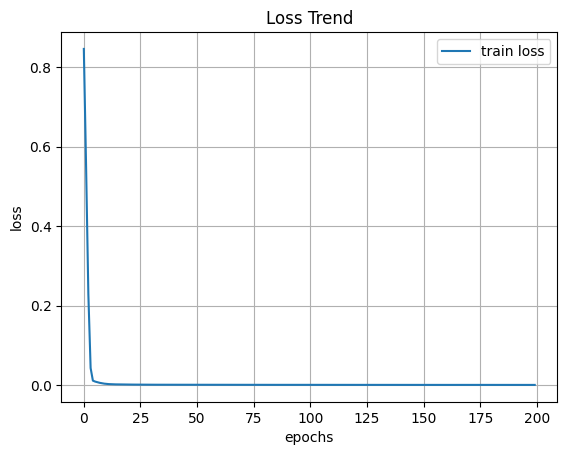

In [29]:
# 시각화
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train loss')
plt.legend()
plt.show()

In [30]:
# test
test_pred_tensor = model(x_test_tensor) # test 예측값

test_pred_numpy = test_pred_tensor.cpu().detach().numpy() # cpu로 자동 미분이 있는 tensor를 연산 기록에서 분리하여 그래프에 추가하지 않고(역전파 방지)  numpy로 변환

pred_inverse = scaler_y.inverse_transform(test_pred_numpy)

y_test_numpy = y_test_tensor.cpu().detach().numpy()

y_test_inverse = scaler_y.inverse_transform(y_test_numpy) # 0~1로 Scaling 되어 있는 것을 원래의 값으로 바꿔서 결과를 보여줌

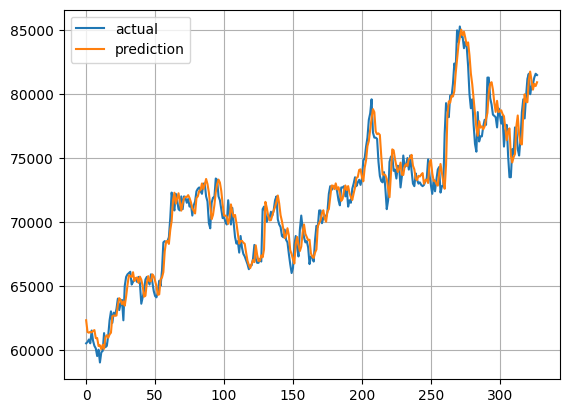

In [31]:
import matplotlib.pyplot as plt

plt.plot(y_test_inverse, label='actual')
plt.plot(pred_inverse, label='prediction')
plt.grid()
plt.legend()

plt.show()